In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from caveclient import CAVEclient

In [193]:
bin_width = 50 * 1000
step_size = 10 * 1000
y_resolution = 4  # nm per voxel

In [205]:
labels = np.array([107000, 147000, 184000, 224000, 265000]) * y_resolution

In [96]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [207]:
nuclei = client.materialize.query_table("nucleus_detection_v0")

In [89]:
col_cells = client.materialize.query_table("allen_v1_column_types_v2")
exc_cells = col_cells.query("classification_system == 'aibs_coarse_excitatory'")
inh_cells = col_cells.query("classification_system == 'aibs_coarse_inhibitory'")
len(exc_cells), len(inh_cells)

(1185, 162)

In [214]:
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

auto_col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox)]

In [97]:
# min is pia border (L1) and max is white matter border (L6)
min_y = min(pt[1] * y_resolution for pt in col_cells.pt_position)
max_y = max(pt[1] * y_resolution for pt in col_cells.pt_position)
min_y, max_y

(321344, 1182080)

In [194]:
exc_soma_densities = []
inh_soma_densities = []
avg_volumes = []  # todo of what cells?  measured in micrometers^3
bin_centers = []
curr_y = min_y
while curr_y < max_y:
    bin_centers.append(curr_y + step_size // 2)
    exc_soma_densities.append(sum(curr_y <= p[1] * y_resolution < curr_y + bin_width for p in exc_cells.pt_position))
    inh_soma_densities.append(sum(curr_y <= p[1] * y_resolution < curr_y + bin_width for p in inh_cells.pt_position))
    these_nuclei = nuclei[list(curr_y <= p[1] * y_resolution < curr_y + step_size for p in nuclei.pt_position)]
    avg_volumes.append(these_nuclei.volume.mean())
    curr_y += step_size
bin_centers = np.array(bin_centers)
exc_soma_densities = np.array(exc_soma_densities, dtype=float) / bin_width
inh_soma_densities = np.array(inh_soma_densities, dtype=float) / bin_width
avg_volumes = np.array(avg_volumes)

L1: low soma density
L2: high soma density
L3: med soma density
L4: high soma density
L5: med soma density, large soma
L6: medhigh soma density

L1-L2	107000

L3-L4	147000
L4-L5	184000
L5-L6	224000
L6-WM	265000

In [195]:
from sklearn import linear_model

In [196]:
degree = 8
varis = np.stack([(bin_centers / 100_000) ** n for n in range(degree)]).T
reg = linear_model.LinearRegression()
reg.fit(varis, exc_soma_densities.reshape(-1, 1))
fit = reg.predict(varis)

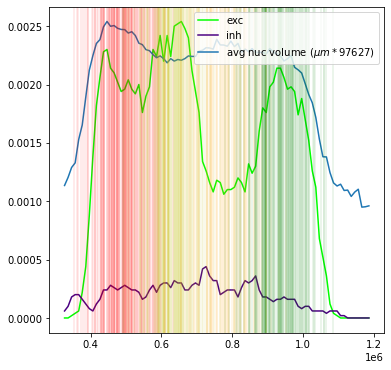

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bin_centers, exc_soma_densities, c="lime", label="exc")
ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh")
ax.plot(bin_centers, avg_volumes * max(exc_soma_densities) / max(avg_volumes), label=f"avg nuc volume ($\mu m * {round(max(avg_volumes) / max(exc_soma_densities))}$)")
# ax.plot(bin_centers, fit, "--", color="lime", label="exc fit")

cells_to_plot = auto_cells
indices_to_plot = np.random.choice(cells_to_plot.index, 500)
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type == "23P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * 4, color="red", alpha=0.1)

for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type == "4P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * 4, color="y", alpha=0.1)
        
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type.startswith("5P"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * 4, color="orange", alpha=0.1)
        
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type in ["6P", "6IT", "6CT"]:
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * 4, color="green", alpha=0.1)

for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type.startswith("Unsure"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * 4, color="brown", alpha=0.1)
        
# for lab in labels:
#     ax.axvline(lab, linestyle="--", color="k")
ax.legend()
plt.show()

Ideas:
Threshholds, except there is a strong weight to match these widths (L1-L2 boundary at 0.4mm, L2/3 0.18mm wide, L4 0.17mm wide

In [ ]:
# L1-L2 boundary
depth = 400_000



In [133]:
exc_cells.cell_type.unique()

array(['6P', '5P_PT', '23P', '4P', '5P_IT', '5P_NP', 'Unsure', '6IT',
       '6CT'], dtype=object)

In [136]:
col_cells.classification_system.unique()

array(['aibs_coarse_nonneuronal', 'aibs_coarse_excitatory',
       'aibs_coarse_error', 'aibs_coarse_inhibitory',
       'aibs_coarse_unclear', 'aibs_coarse_neuron'], dtype=object)

No handles with labels found to put in legend.


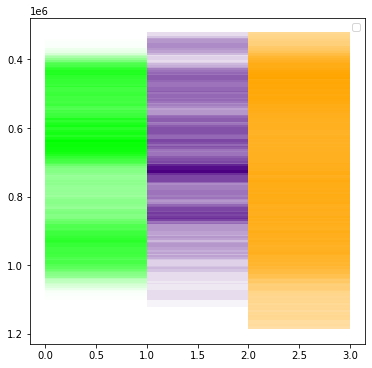

In [113]:
# todo fill with alpha = density
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(bin_centers)):
        bin_start, bin_end = bin_centers[i] - step_size // 2, bin_centers[i] + step_size // 2
        ax.fill_between([0, 1], [bin_start]*2, [bin_end]*2, alpha=exc_soma_densities[i] / max(exc_soma_densities), color="lime", edgecolor=None)
        ax.fill_between([1, 2], [bin_start]*2, [bin_end]*2, alpha=inh_soma_densities[i] / max(inh_soma_densities), color="indigo", edgecolor=None)
        ax.fill_between([2, 3], [bin_start]*2, [bin_end]*2, alpha=avg_volumes[i] / max(avg_volumes), color="orange", edgecolor=None)
    
ax.invert_yaxis()
ax.legend()
plt.show()